# Stay Alert! The Ford Challenge

Вождение в нетрезвом состоянии может привести к летальному исходу. Цель состоит в разработке классификатора, который будет определять, находится водитель в состоянии боевой готовности или нет, используя данные, полученные во время вождения.

# Исследование данных

In [1]:
# !kaggle competitions download -c stayalert

In [2]:
# !unzip stayalert.zip

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
# Standard python libraries
import os

# Essential DS libraries
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix

# LightAutoML presets, task and report generation
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco, ReportDecoUtilized
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML

'nlp' extra dependency package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.


/home/kalmykov/.local/lib/python3.10/site-packages/lightautoml/text/tokenizer.py:21: UserWarning: 'nltk' - package isn't installed
  warnings.warn("'nltk' - package isn't installed")
/home/kalmykov/.local/lib/python3.10/site-packages/lightautoml/transformers/text.py:22: UserWarning: 'gensim' - package isn't installed
  warnings.warn("'gensim' - package isn't installed")
/home/kalmykov/.local/lib/python3.10/site-packages/lightautoml/ml_algo/dl_model.py:42: UserWarning: 'transformers' - package isn't installed
  warnings.warn("'transformers' - package isn't installed")


In [5]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 300
TARGET_NAME = 'IsAlert'

In [6]:
DATASET_DIR = './data/'
DATASET_NAME = 'fordTrain.csv'
DATASET_FULLNAME = os.path.join(DATASET_DIR, DATASET_NAME)

In [7]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

In [8]:
data = pd.read_csv(DATASET_FULLNAME)

In [9]:
data = data.drop(['TrialID', 'ObsNum'], axis=1)

In [10]:
# Численный анализ целевой переменной
target_distribution = data[TARGET_NAME].value_counts()
print(f'Target distribution:\n{target_distribution}')

Target distribution:
IsAlert
1    349785
0    254544
Name: count, dtype: int64


### Распределение таргета

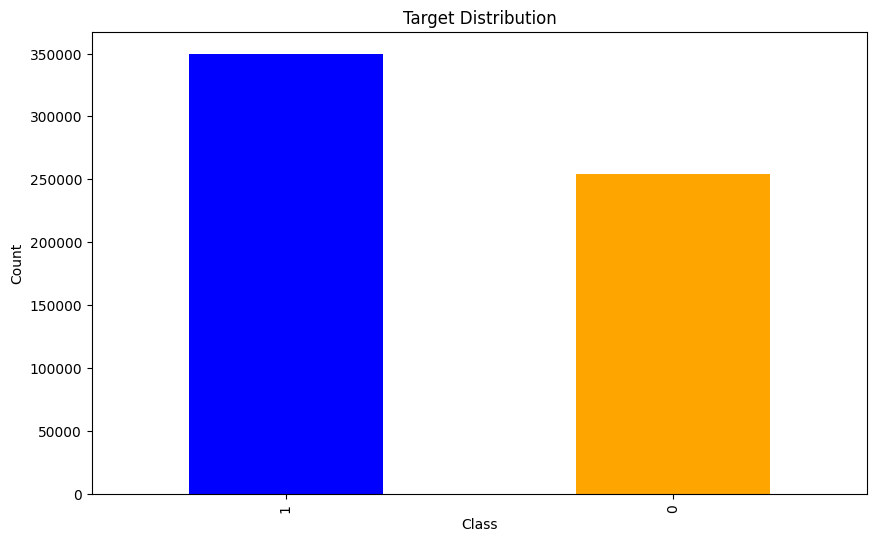

In [11]:
# Визуализация распределения целевой переменной
plt.figure(figsize=(10, 6))
data[TARGET_NAME].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Target Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

### Поиск столбцов не имеющих различных значений

In [ ]:
for column in data.columns:
    length = len(data[column].unique())
    print(column, length)
    if length == 1:
        data.drop(column, axis=1, inplace=True)

IsAlert 2
P1 113345
P2 141467
P3 409
P4 409
P5 1219
P6 419
P7 419
P8 1
E1 13640
E2 34569
E3 3
E4 252
E5 254
E6 247
E7 26
E8 10
E9 2
E10 123
E11 120
V1 12418
V2 90
V3 34
V4 324
V5 2
V6 2787
V7 1
V8 323
V9 1
V10 5
V11 180939


### Типизация признаков

In [13]:
# Типизация признаков
numeric_features = data.drop('IsAlert', axis=1).select_dtypes(include=[np.number]).columns.tolist()

categorical_features = []
boolean_features = []
for column in data.columns[1:]:
    if 2 < len(data[column].unique()) <= 35:
        categorical_features.append(column)
        numeric_features.remove(column)
    if len(data[column].unique()) == 2:
        boolean_features.append(column)
        numeric_features.remove(column)

print(f'Numeric features: {numeric_features}')
print(f'Numeric features: {categorical_features}')
# Распределение признаков
data[numeric_features].describe()

Numeric features: ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'E1', 'E2', 'E4', 'E5', 'E6', 'E10', 'E11', 'V1', 'V2', 'V4', 'V6', 'V8', 'V11']
Numeric features: ['E3', 'E7', 'E8', 'V3', 'V10']


,P1,P2,P3,P4,P5,P6,P7,E1,E2,E4,E5,E6,E10,E11,V1,V2,V4,V6,V8,V11
count,604329.000000,604329.000000,604329.000000,604329.000000,604329.000000,604329.000000,604329.000000,604329.000000,604329.000000,604329.000000,604329.000000,604329.000000,604329.000000,604329.000000,604329.000000,604329.000000,604329.000000,604329.000000,604329.000000,604329.000000
mean,35.449020,11.996525,1026.671035,64.061965,0.178923,845.384610,77.887628,10.512332,102.790045,-4.230136,0.016262,358.674738,63.311256,1.315265,76.965412,-0.037710,19.961030,1715.688383,12.710354,11.668277
std,7.484629,3.760292,309.277877,19.755950,0.372309,2505.335141,18.577930,14.049071,127.258629,35.508596,0.002304,27.399973,18.891029,5.247204,44.387031,0.403896,63.269456,618.176470,11.532085,9.934423
min,-22.481200,-45.629200,504.000000,23.885300,0.038920,128.000000,0.262224,0.000000,0.000000,-250.000000,0.008000,260.000000,0.000000,0.000000,0.000000,-4.795000,0.000000,0.000000,0.000000,1.676730
25%,31.758100,9.903540,792.000000,49.180300,0.092110,668.000000,66.666700,0.000000,0.000000,-8.000000,0.015686,348.000000,52.000000,0.000000,41.930000,-0.175000,1.487500,1259.000000,0.000000,7.947680
50%,34.145100,11.400400,1000.000000,60.000000,0.105083,800.000000,75.000000,0.000000,0.000000,0.000000,0.016001,365.000000,67.000000,0.000000,100.400000,0.000000,3.018750,1994.000000,12.800000,10.772600
75%,37.311900,13.644200,1220.000000,75.757600,0.138814,900.000000,89.820400,28.240000,211.584000,6.000000,0.016694,367.000000,73.000000,0.000000,108.500000,0.070000,7.481250,2146.000000,21.900000,15.270900
max,101.351000,71.173700,2512.000000,119.048000,27.202200,228812.000000,468.750000,243.991000,359.995000,260.000000,0.023939,513.000000,127.000000,52.400000,129.700000,3.990000,484.488000,4892.000000,82.100000,262.534000


### Распределение категориальных признаков

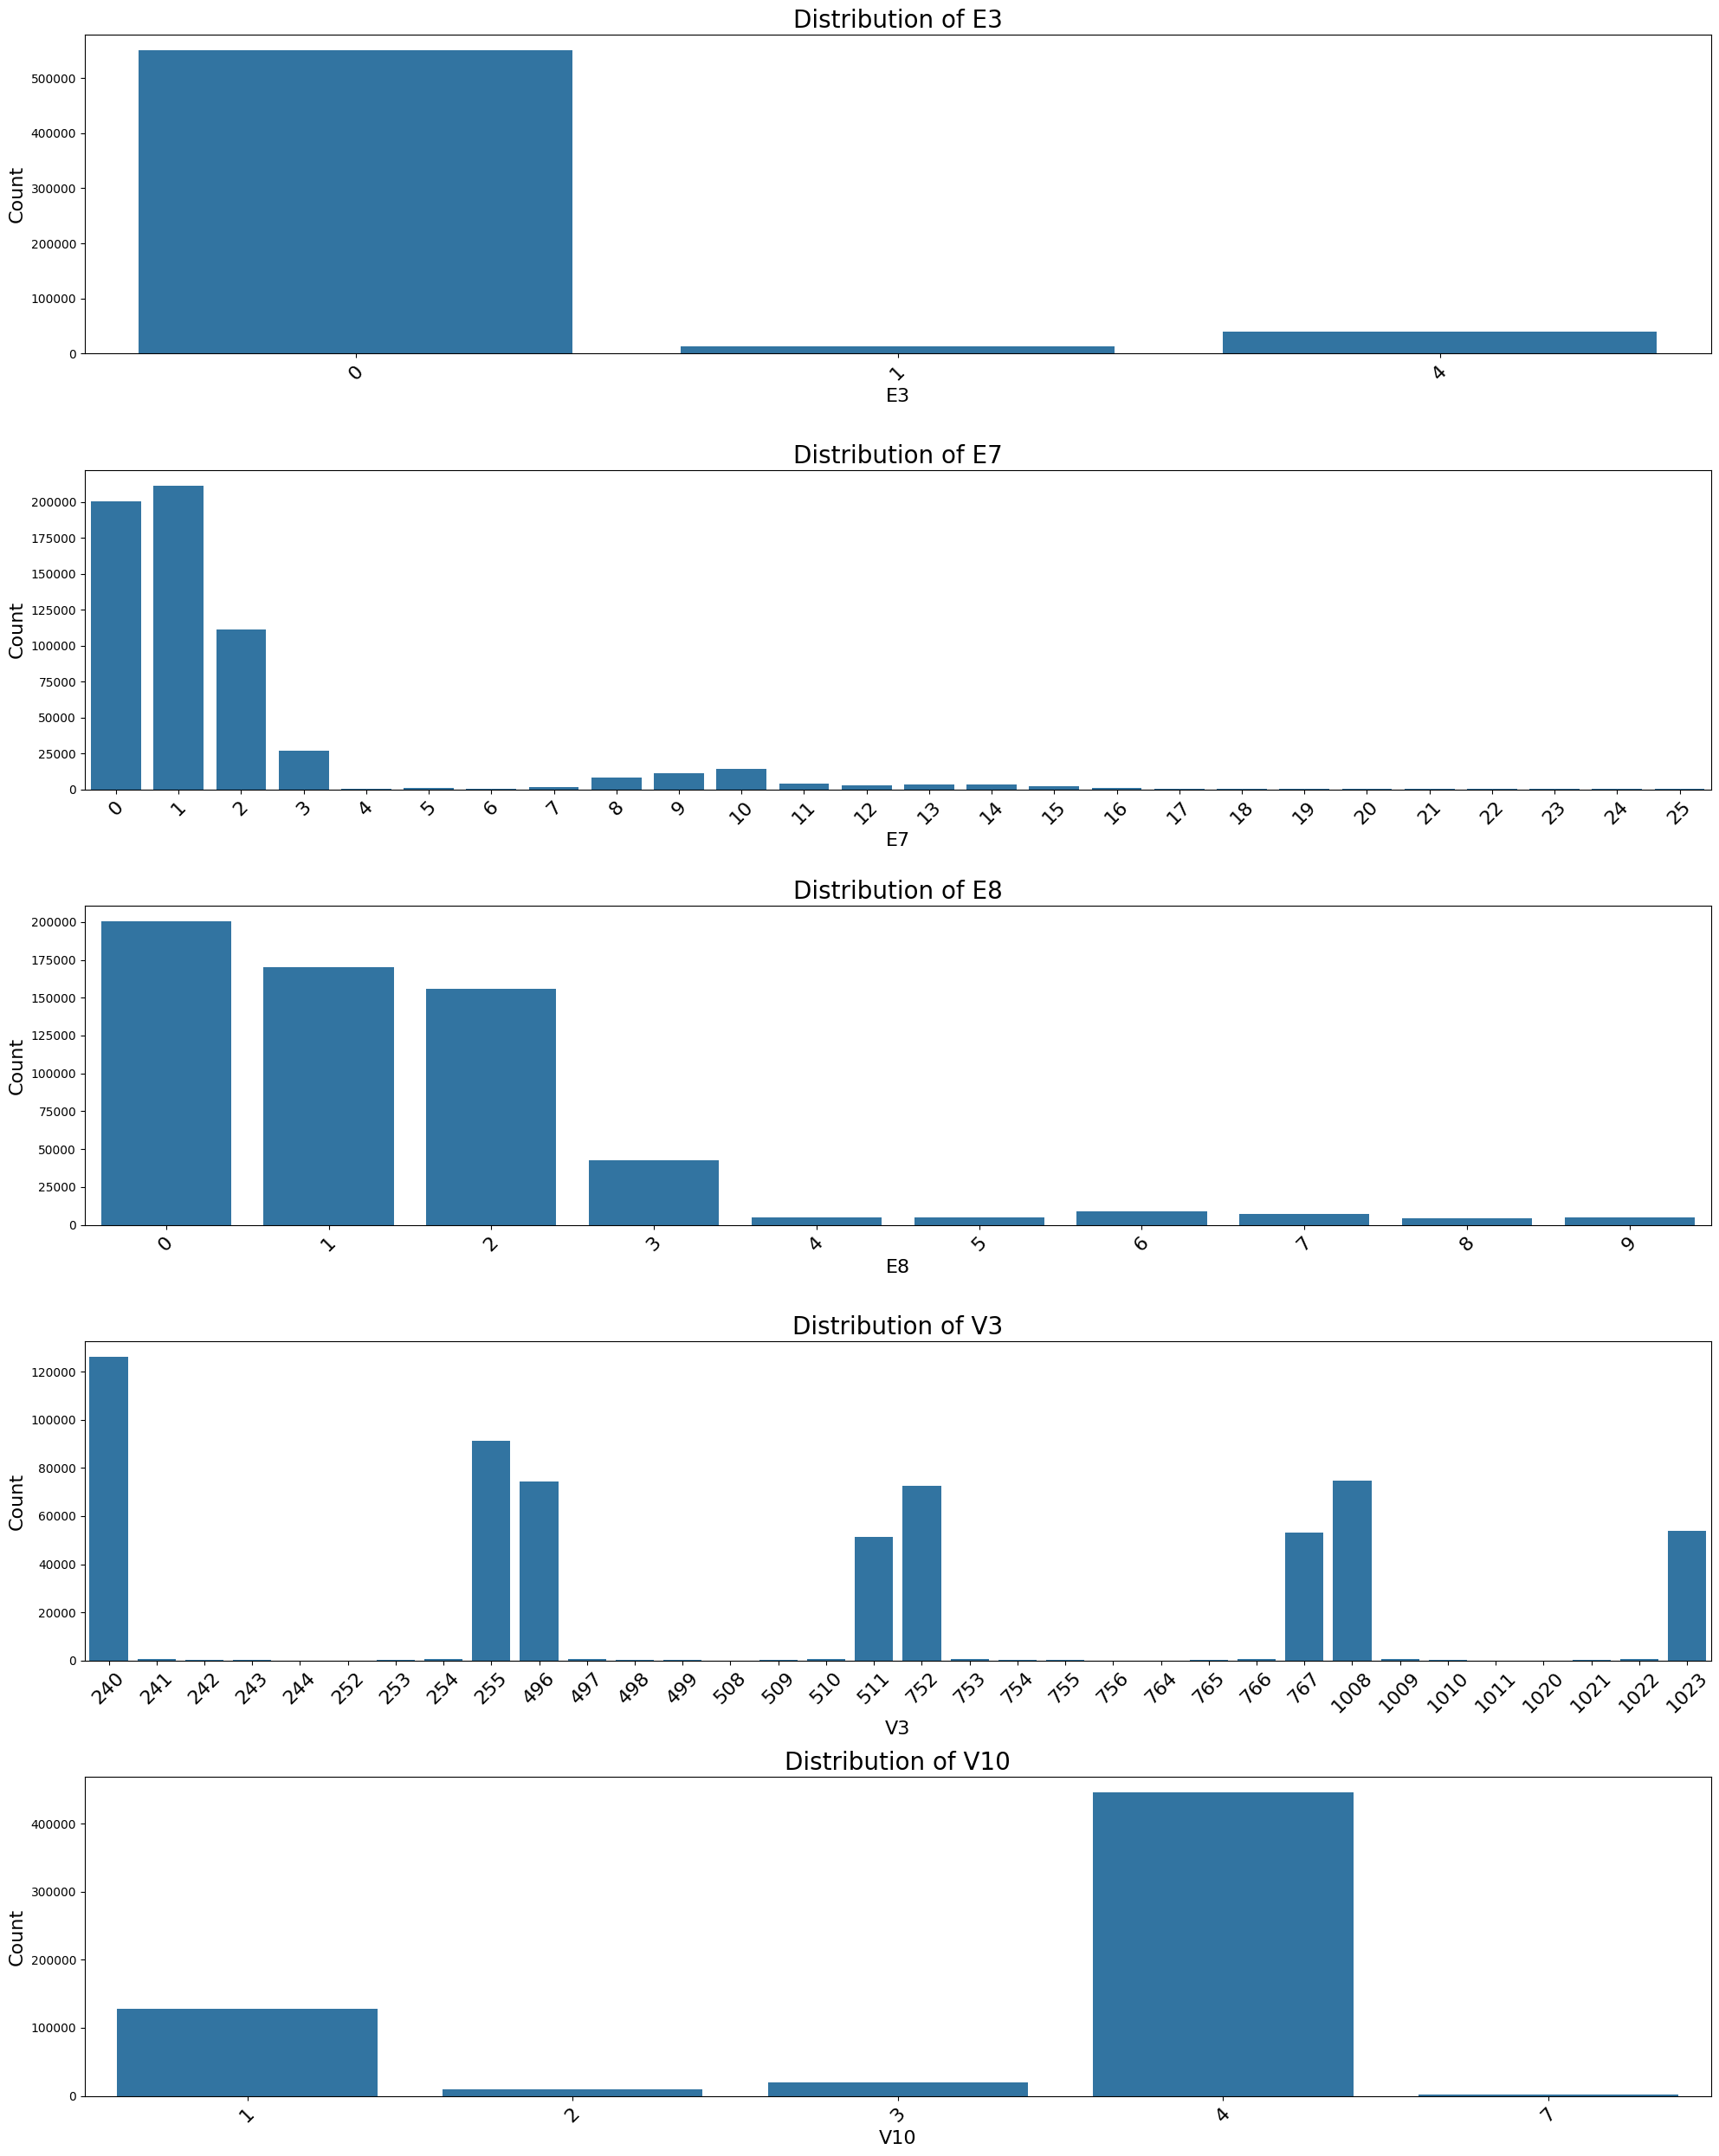

In [14]:
# Определение количества строк и столбцов для сетки подграфиков
num_features = len(categorical_features)
num_cols = 1  # Количество столбцов в сетке
num_rows = (num_features + num_cols - 1) // num_cols  # Количество строк в сетке

# Создание сетки подграфиков
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
axes = axes.flatten()

# Построение графиков распределения для каждой категориальной переменной
for i, feature in enumerate(categorical_features):
    sns.countplot(data=data, x=feature, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}', fontsize=20)
    axes[i].set_xlabel(feature, fontsize=16)
    axes[i].set_ylabel('Count', fontsize=16)
    axes[i].set_xticks(range(len(axes[i].get_xticklabels())))
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, fontsize=16)

# Удаление лишних подграфиков, если их количество не кратно количеству признаков
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Выявление аномальных значений

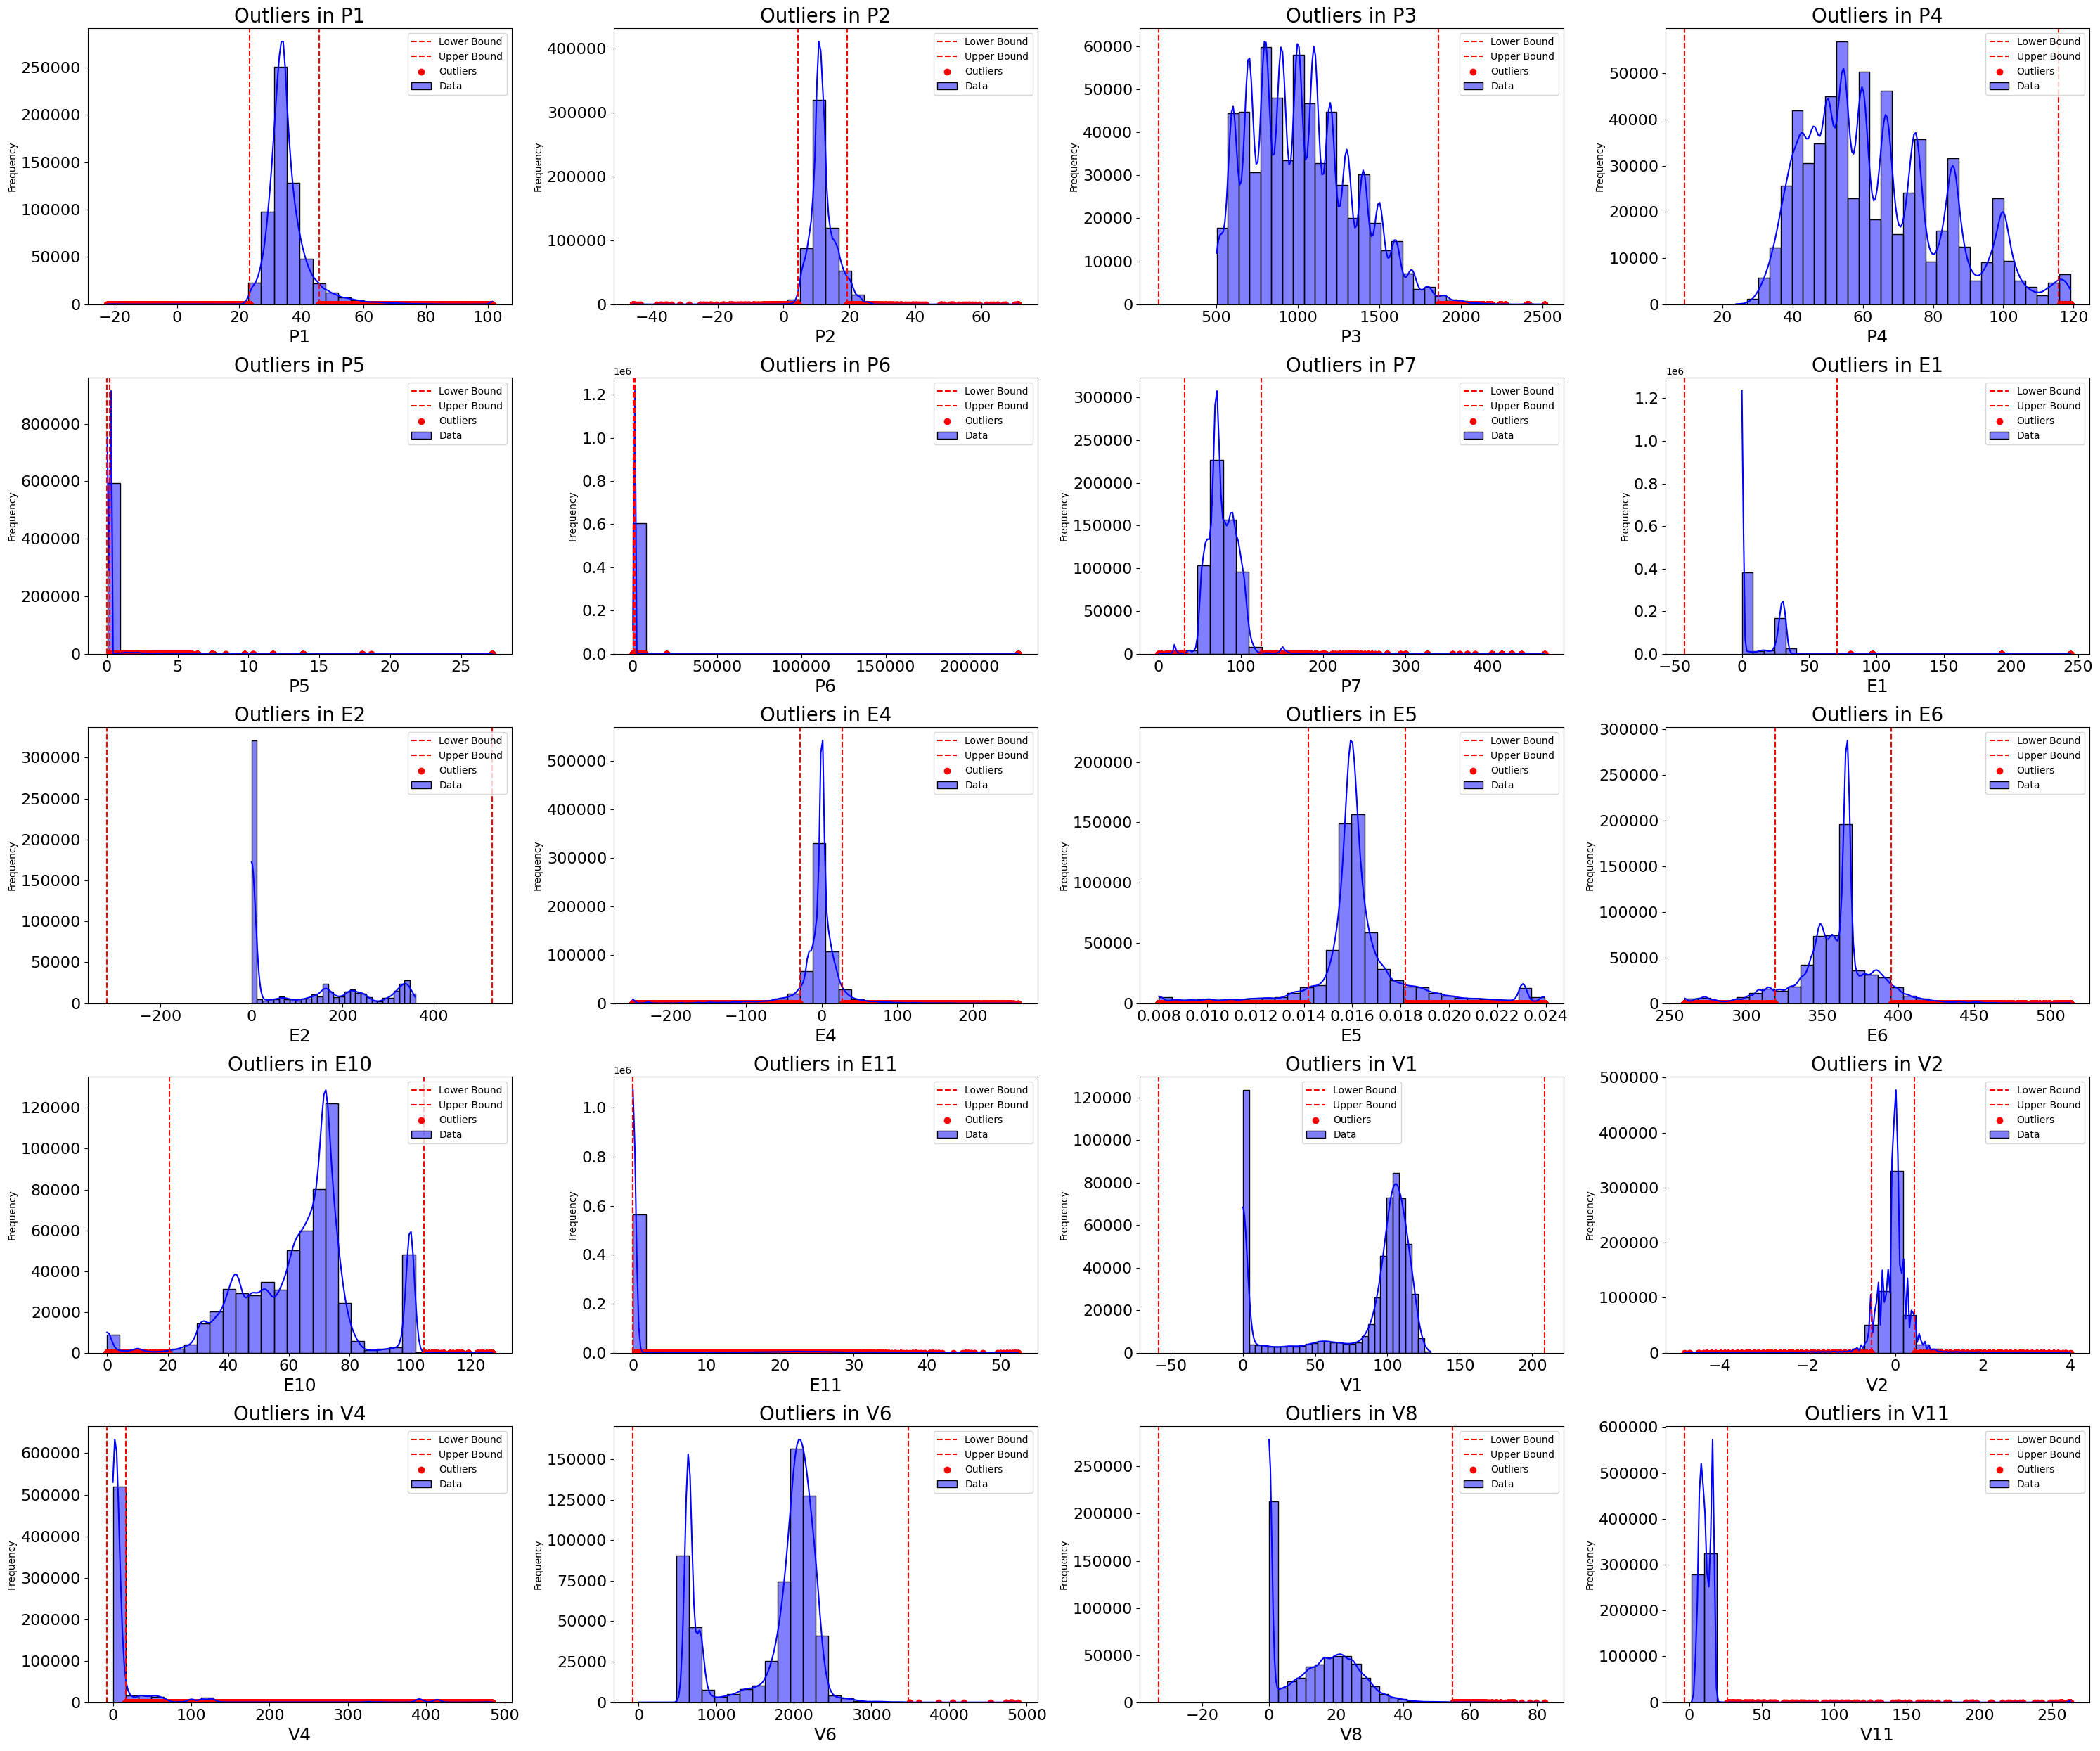

In [15]:
# Выявление аномальных значений
num_features = len(numeric_features)
num_cols = 4  # Количество столбцов в сетке
num_rows = (num_features + num_cols - 1) // num_cols  # Количество строк в сетке

fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 5 * num_rows))
axes = axes.flatten()

for i, feature in enumerate(numeric_features):
    q1 = data[feature].quantile(0.25)
    q3 = data[feature].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = data[(data[feature] < lower_bound) | (data[feature] > upper_bound)]

    sns.histplot(data[feature], kde=True, bins=30, color='blue', ax=axes[i], label='Data')
    axes[i].axvline(lower_bound, color='r', linestyle='--', label='Lower Bound')
    axes[i].axvline(upper_bound, color='r', linestyle='--', label='Upper Bound')
    axes[i].scatter(outliers[feature], [0]*outliers.shape[0], color='red', label='Outliers')
    axes[i].set_title(f'Outliers in {feature}', fontsize=20)
    axes[i].set_xlabel(feature, fontsize=18)
    axes[i].set_ylabel('Frequency')
    axes[i].tick_params(axis='y', labelsize=16)
    axes[i].tick_params(axis='x', labelsize=16)
    axes[i].legend()

# Удаляем лишние подграфики, если их количество не кратно количеству признаков
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

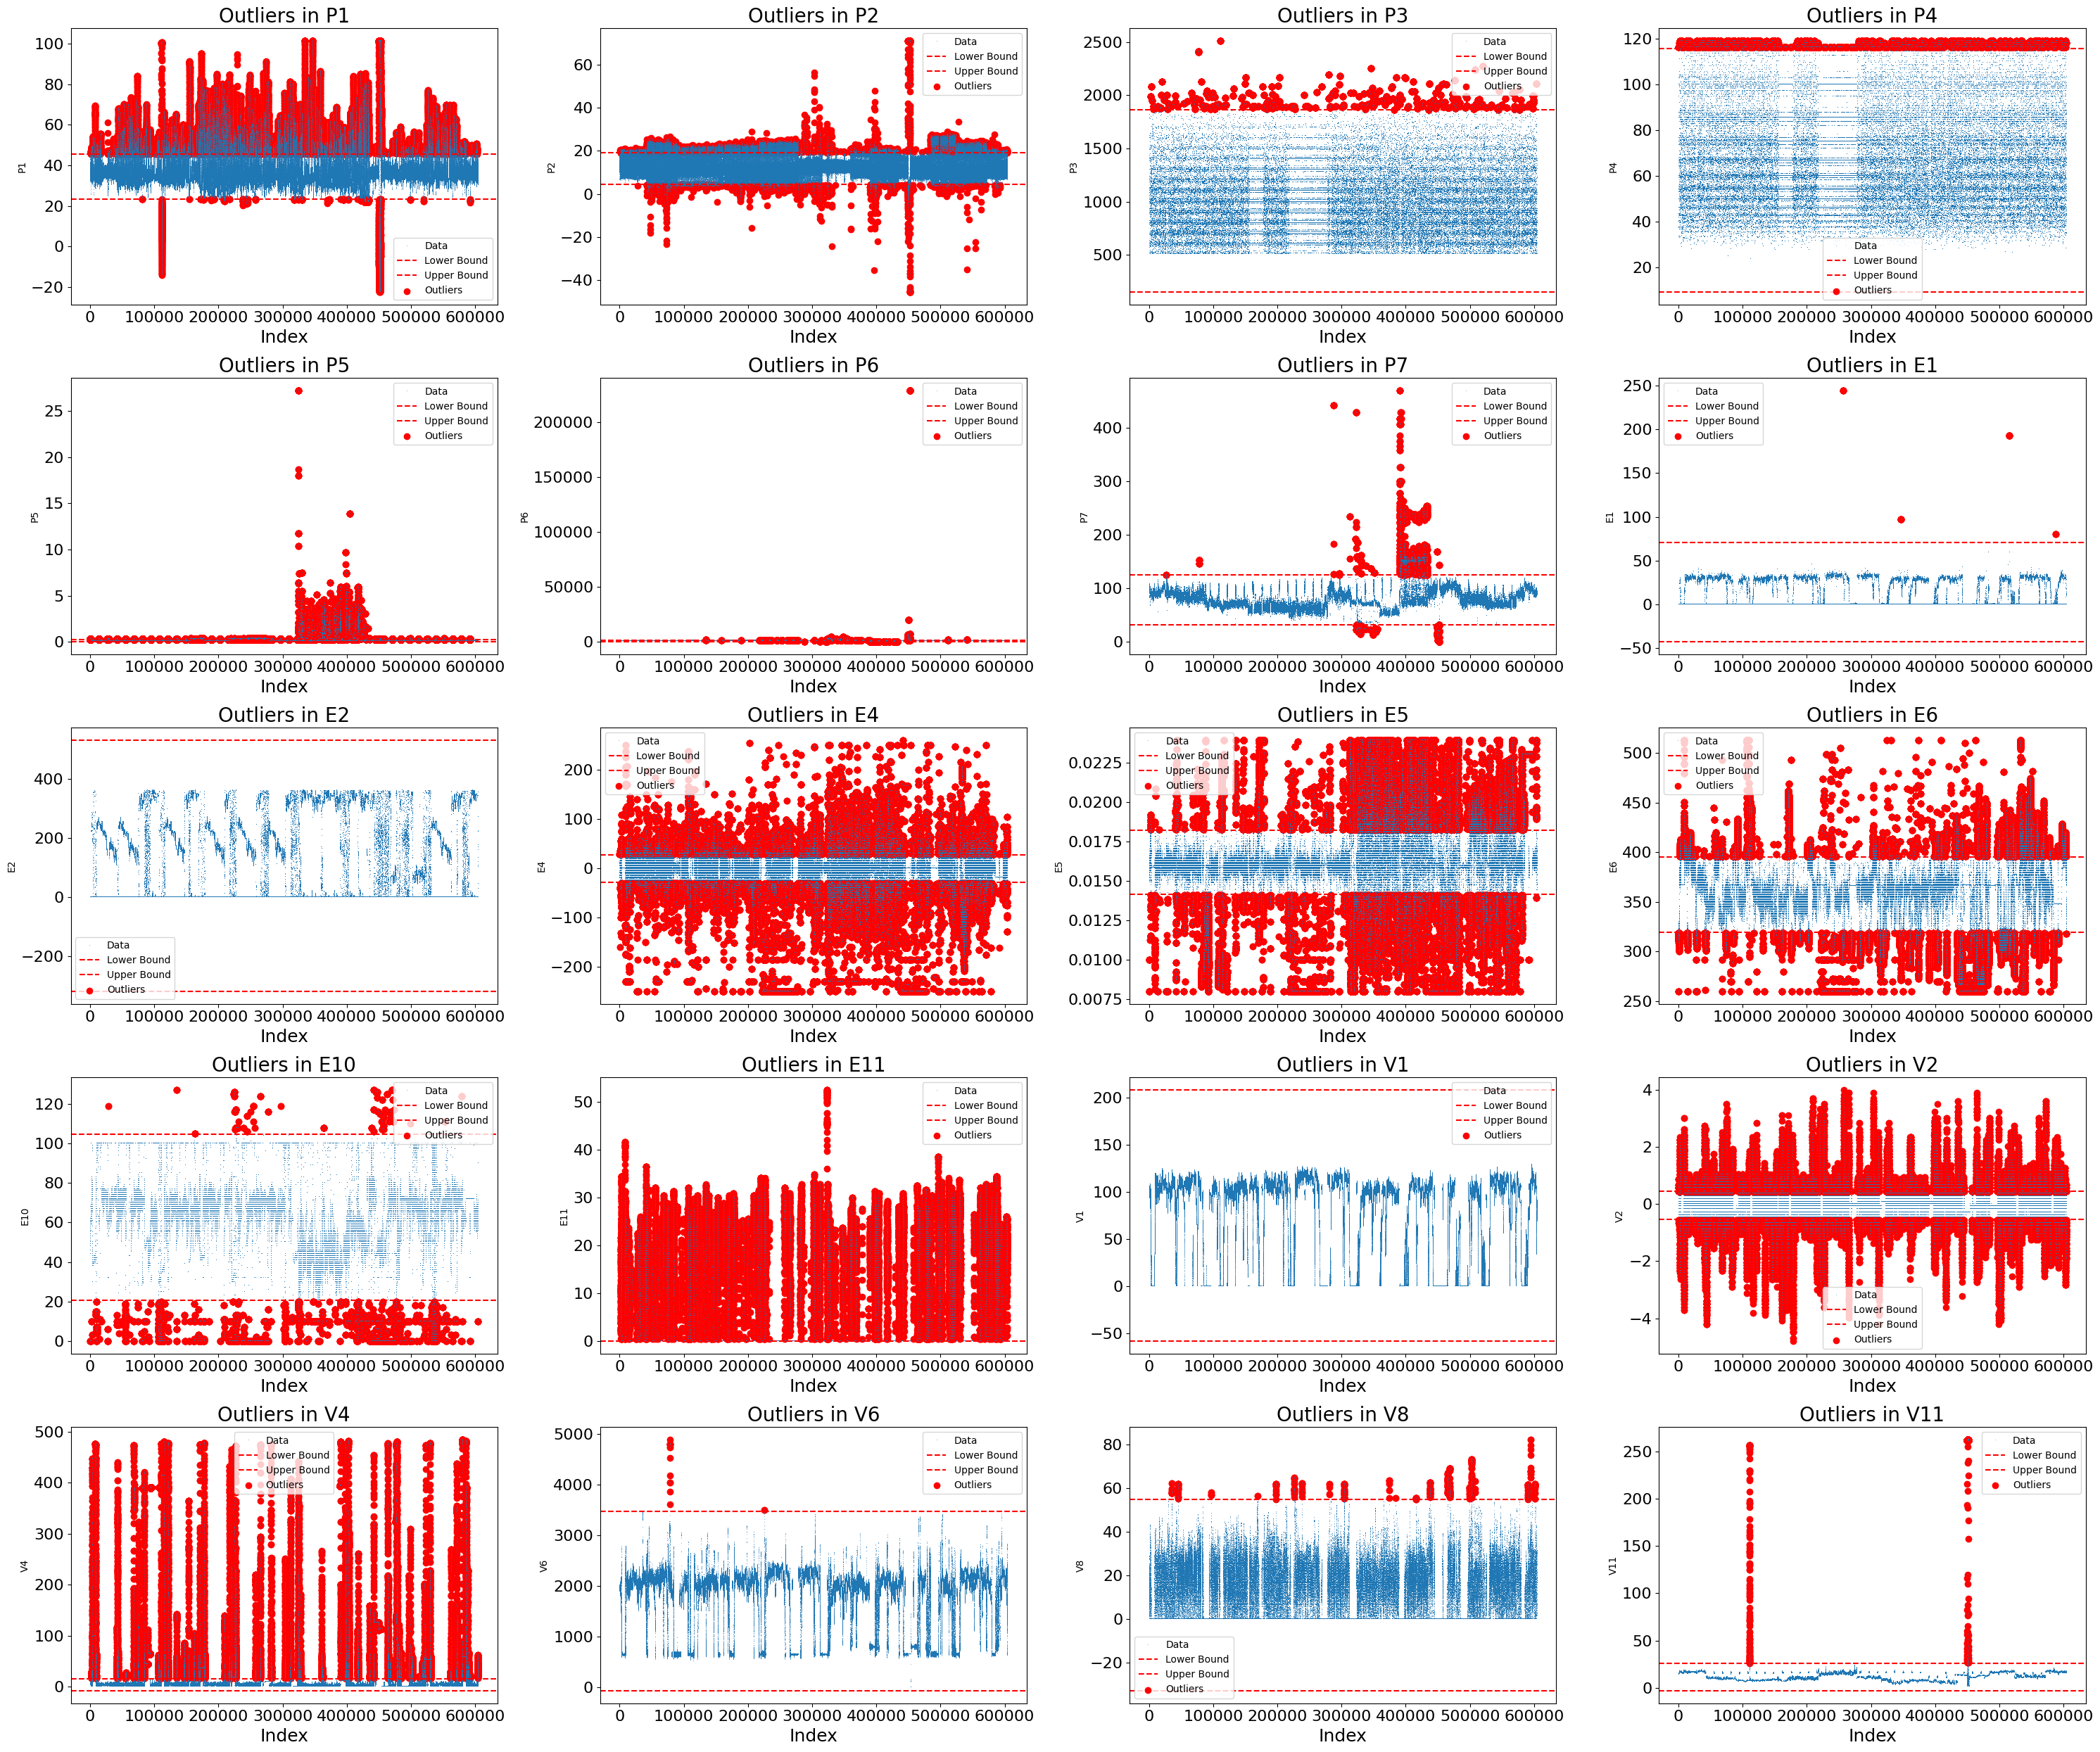

In [16]:
# Выявление аномальных значений
num_features = len(numeric_features)
num_cols = 4  # Количество столбцов в сетке
num_rows = (num_features + num_cols - 1) // num_cols  # Количество строк в сетке

fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 5 * num_rows))
axes = axes.flatten()

for i, feature in enumerate(numeric_features):
    q1 = data[feature].quantile(0.25)
    q3 = data[feature].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = data[(data[feature] < lower_bound) | (data[feature] > upper_bound)]

    axes[i].plot(data.index, data[feature], ',', label='Data', alpha=0.5)
    axes[i].axhline(lower_bound, color='r', linestyle='--', label='Lower Bound')
    axes[i].axhline(upper_bound, color='r', linestyle='--', label='Upper Bound')
    axes[i].scatter(outliers.index, outliers[feature], color='red', label='Outliers')
    axes[i].set_title(f'Outliers in {feature}', fontsize=20)
    axes[i].set_xlabel('Index', fontsize=18)
    axes[i].set_ylabel(feature)
    axes[i].tick_params(axis='y', labelsize=16)
    axes[i].tick_params(axis='x', labelsize=16)
    axes[i].legend()

# Удаляем лишние подграфики, если их количество не кратно количеству признаков
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Анализ зависимостей между признаками

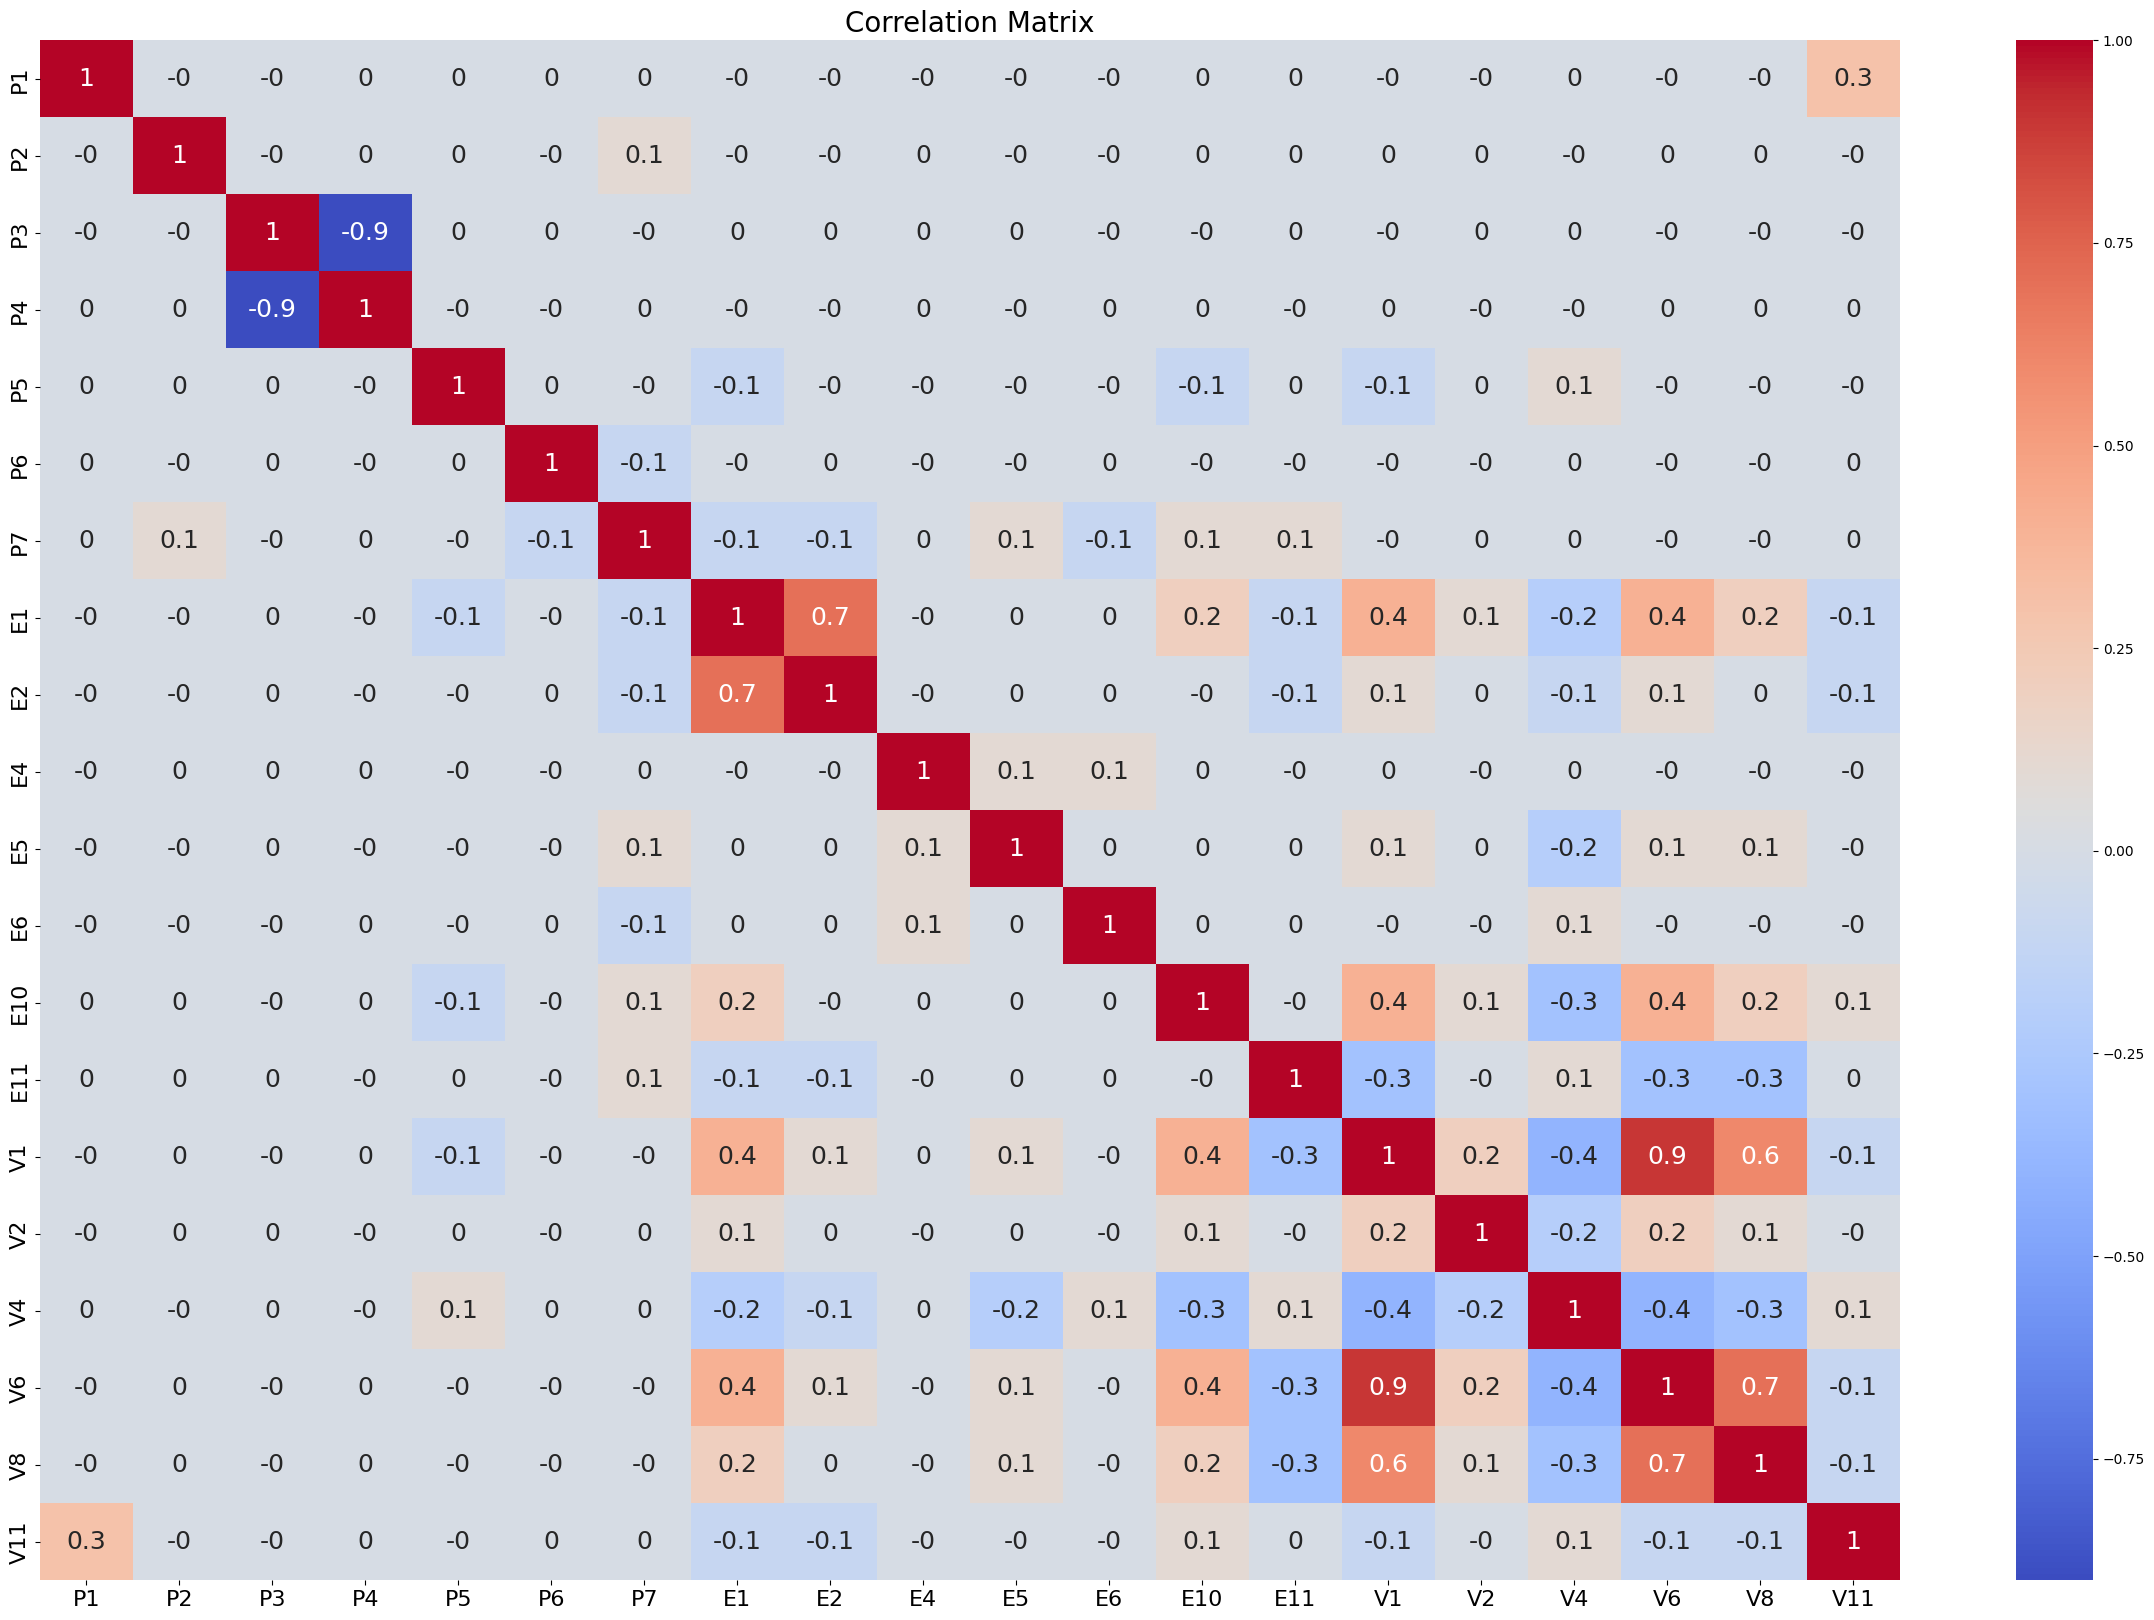

In [17]:
# Анализ зависимостей между признаками
correlation_matrix = data[numeric_features].corr().round(1)
plt.figure(figsize=(30, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', annot_kws={"size": 18})
plt.tick_params(axis='y', labelsize=16)
plt.tick_params(axis='x', labelsize=16)
plt.title('Correlation Matrix', fontsize=20)
plt.show()


### Анализ пропущенных значений

In [18]:
# Анализ пропущенных значений
missing_values = data.isna().sum()
print(f'Missing values:\n{missing_values}')

Missing values:
IsAlert    0
P1         0
P2         0
P3         0
P4         0
P5         0
P6         0
P7         0
E1         0
E2         0
E3         0
E4         0
E5         0
E6         0
E7         0
E8         0
E9         0
E10        0
E11        0
V1         0
V2         0
V3         0
V4         0
V5         0
V6         0
V8         0
V10        0
V11        0
dtype: int64


### Распределения численных признаков

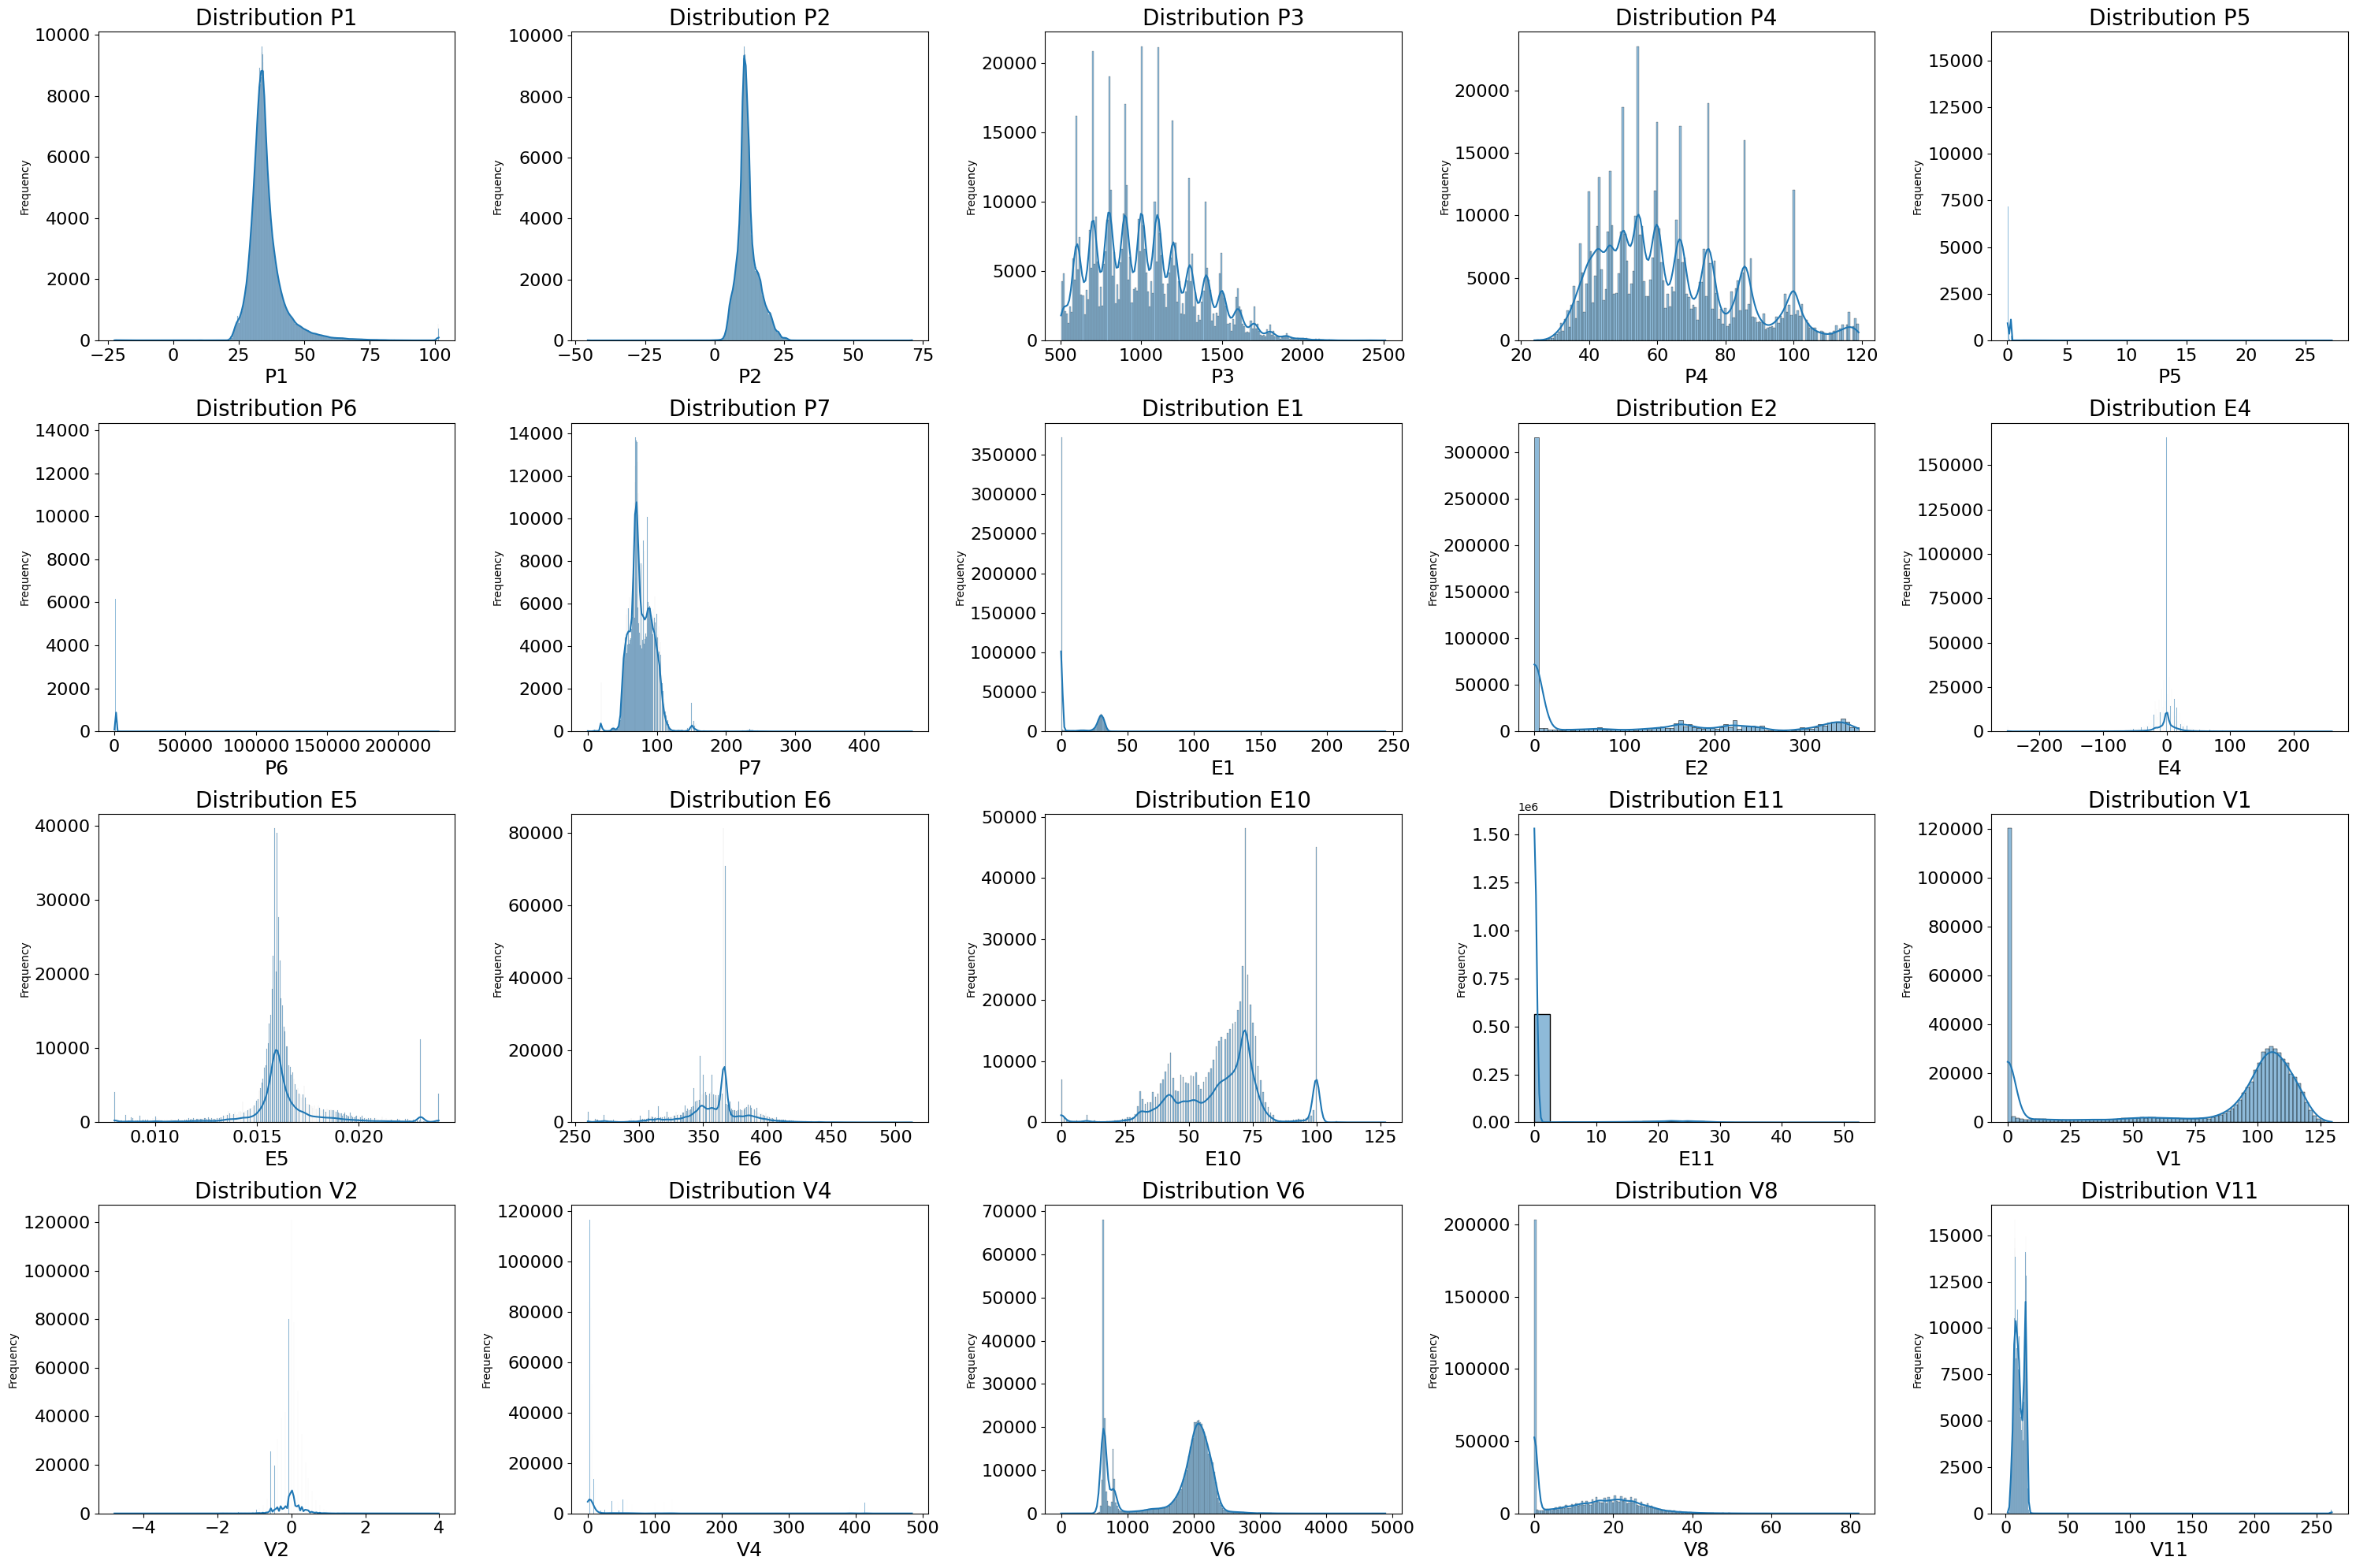

In [19]:
# Определим количество строк и столбцов для сетки
num_features = len(numeric_features)
num_cols = 5  # Количество столбцов в сетке
num_rows = (num_features + num_cols - 1) // num_cols  # Количество строк в сетке

# Создаем сетку подграфиков
fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 5 * num_rows))
axes = axes.flatten()  # Преобразуем в одномерный массив для удобства

# Рисуем гистограммы для каждого числового признака
for i, feature in enumerate(numeric_features):
    sns.histplot(data[feature], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution {feature}', fontsize=20)
    axes[i].set_xlabel(feature, fontsize=18)
    axes[i].set_ylabel('Frequency')
    axes[i].tick_params(axis='y', labelsize=16)
    axes[i].tick_params(axis='x', labelsize=16)

# Удаляем лишние подграфики, если их количество не кратно количеству признаков
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Обработка данных

In [20]:
train_data, test_data = train_test_split(
    data, 
    test_size=TEST_SIZE, 
    stratify=data[TARGET_NAME], 
    random_state=RANDOM_STATE
)

print(f'Data is splitted. Parts sizes: train_data = {train_data.shape}, test_data = {test_data.shape}')

train_data.head()

Data is splitted. Parts sizes: train_data = (483463, 28), test_data = (120866, 28)


,IsAlert,P1,P2,P3,P4,P5,P6,P7,E1,E2,...,E11,V1,V2,V3,V4,V5,V6,V8,V10,V11
430139,0,49.3883,10.34600,876,68.4932,0.094705,876,68.4932,0.000,0.000,...,0.0,100.63,0.070,496,1.48750,0,2024,8.9,4,6.61645
130631,0,30.1531,8.69013,1180,50.8475,0.076542,864,69.4444,25.882,219.849,...,0.0,85.50,0.070,1008,4.50625,0,1729,20.6,4,7.16579
525724,1,39.3587,15.30630,832,72.1154,0.271141,764,78.5340,0.000,0.000,...,13.6,94.26,0.280,1008,4.50625,0,1842,0.0,4,14.96040
103314,1,33.3909,7.94298,704,85.2273,0.096002,908,66.0793,0.000,0.000,...,0.0,109.55,-0.175,767,0.00000,0,2139,18.0,4,6.17326
327774,1,45.3279,12.91610,536,111.9400,0.450171,784,76.5306,0.000,0.000,...,0.0,53.49,-0.665,767,16.49370,1,2204,25.8,3,8.14376


# Решение LAMA TabularAutoML

In [21]:
task = Task('binary')

In [22]:
roles = {
    'target': TARGET_NAME,
    'drop': ['TrialID']
}

In [23]:
RD = ReportDeco(output_path='tabularAutoML_model_report')

automl = TabularAutoML(
    task=task,  # required
    timeout=TIMEOUT,
    cpu_limit=N_THREADS,
    reader_params={'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

automl_rd = RD(automl)

In [24]:
out_of_fold_predictions = automl_rd.fit_predict(train_data, roles = roles, verbose = 1)

[23:04:13] Stdout logging level is INFO.
[23:04:13] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[23:04:13] Task: binary

[23:04:13] Start automl preset with listed constraints:
[23:04:13] - time: 300.00 seconds
[23:04:13] - CPU: 4 cores
[23:04:13] - memory: 16 GB

[23:04:13] Train data shape: (483463, 28)

[23:04:18] Layer 1 train process start. Time left 294.58 secs
[23:04:38] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[23:04:55] Time limit exceeded after calculating fold 3

[23:04:55] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.9361030809747684
[23:04:55] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[23:04:55] Time left 257.27 secs

[23:06:16] Selector_LightGBM fitting and predicting completed
[23:06:36] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[23:08:47] Time limit exceeded after calculating fold 0

[23:08:47] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.9985809326174687
[23:08:47] 

In [25]:
train_predictions = automl_rd.predict(train_data)
print(f'Prediction for train_data:\n{train_predictions}\nShape = {train_predictions.shape}')

Prediction for train_data:
array([[2.3541250e-05],
       [5.7271047e-04],
       [9.9999410e-01],
       ...,
       [9.9993354e-01],
       [1.7879003e-03],
       [9.9949563e-01]], dtype=float32)
Shape = (483463, 1)


In [26]:
test_predictions = automl_rd.predict(test_data)
print(f'Prediction for test_data:\n{test_predictions}\nShape = {test_predictions.shape}')

Prediction for test_data:
array([[9.9993831e-01],
       [9.9746978e-01],
       [2.1476602e-05],
       ...,
       [9.9999326e-01],
       [9.9776852e-01],
       [9.9903667e-01]], dtype=float32)
Shape = (120866, 1)


In [27]:
lama_train_roc = roc_auc_score(train_data[TARGET_NAME].values, train_predictions.data[:, 0])
lama_test_roc = roc_auc_score(test_data[TARGET_NAME].values, test_predictions.data[:, 0])
print(f'OOF score: {lama_train_roc}')
print(f'HOLDOUT score: {lama_test_roc}')

OOF score: 0.9999112423707072
HOLDOUT score: 0.9992053137847469


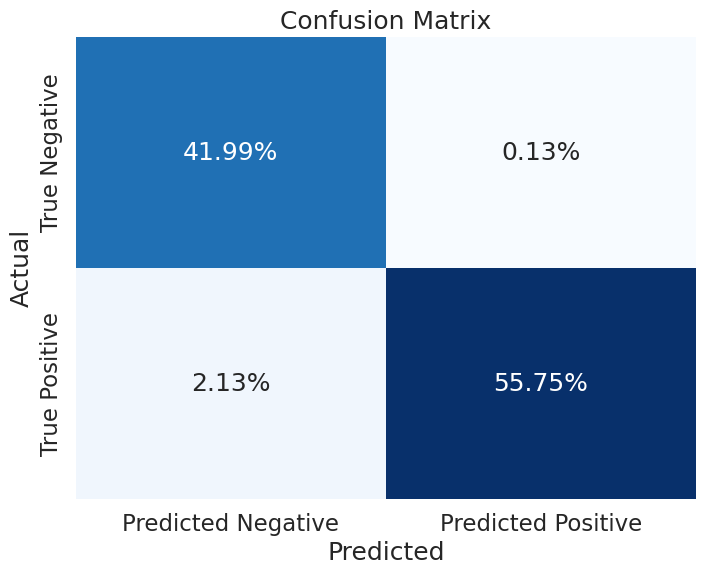

In [28]:
lama_conf_matrix = confusion_matrix(test_data[TARGET_NAME].values, np.int32(np.round(test_predictions.data[:, 0], 1)))
lama_percentage_matrix = (lama_conf_matrix / lama_conf_matrix.sum().sum())
# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(lama_percentage_matrix, annot=True, fmt='.2%', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['True Negative', 'True Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

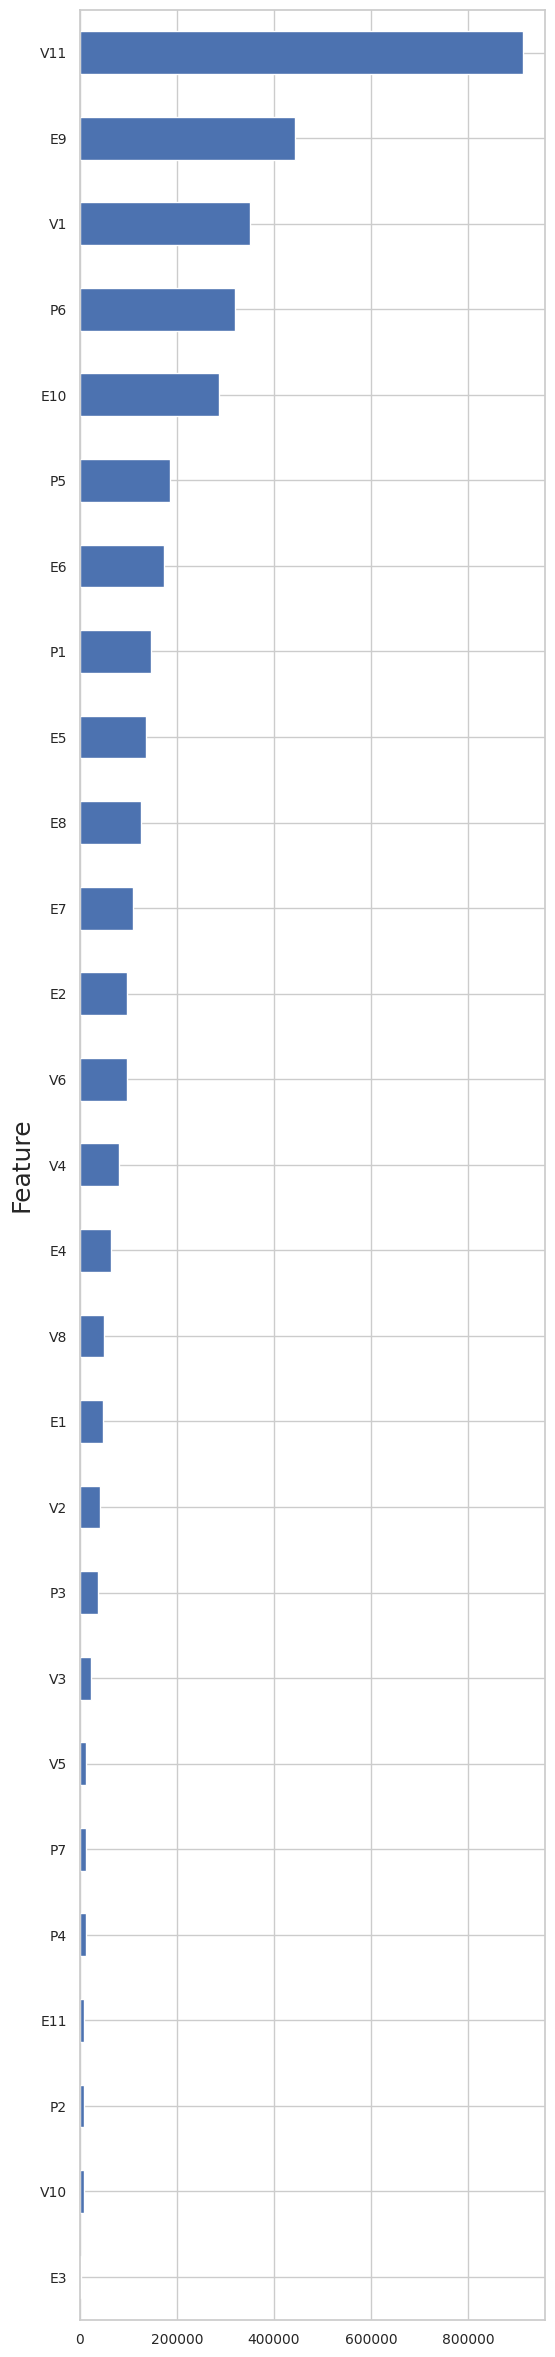

In [29]:
fast_fi = automl_rd.model.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.barh(figsize=(6, 30), grid=True, rot=0)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.gca().invert_yaxis()
plt.show()

In [30]:
# Accurate feature importances calculation (Permutation importances) -  can take long time to calculate
accurate_fi = automl_rd.model.get_feature_scores('accurate', test_data, silent=False)

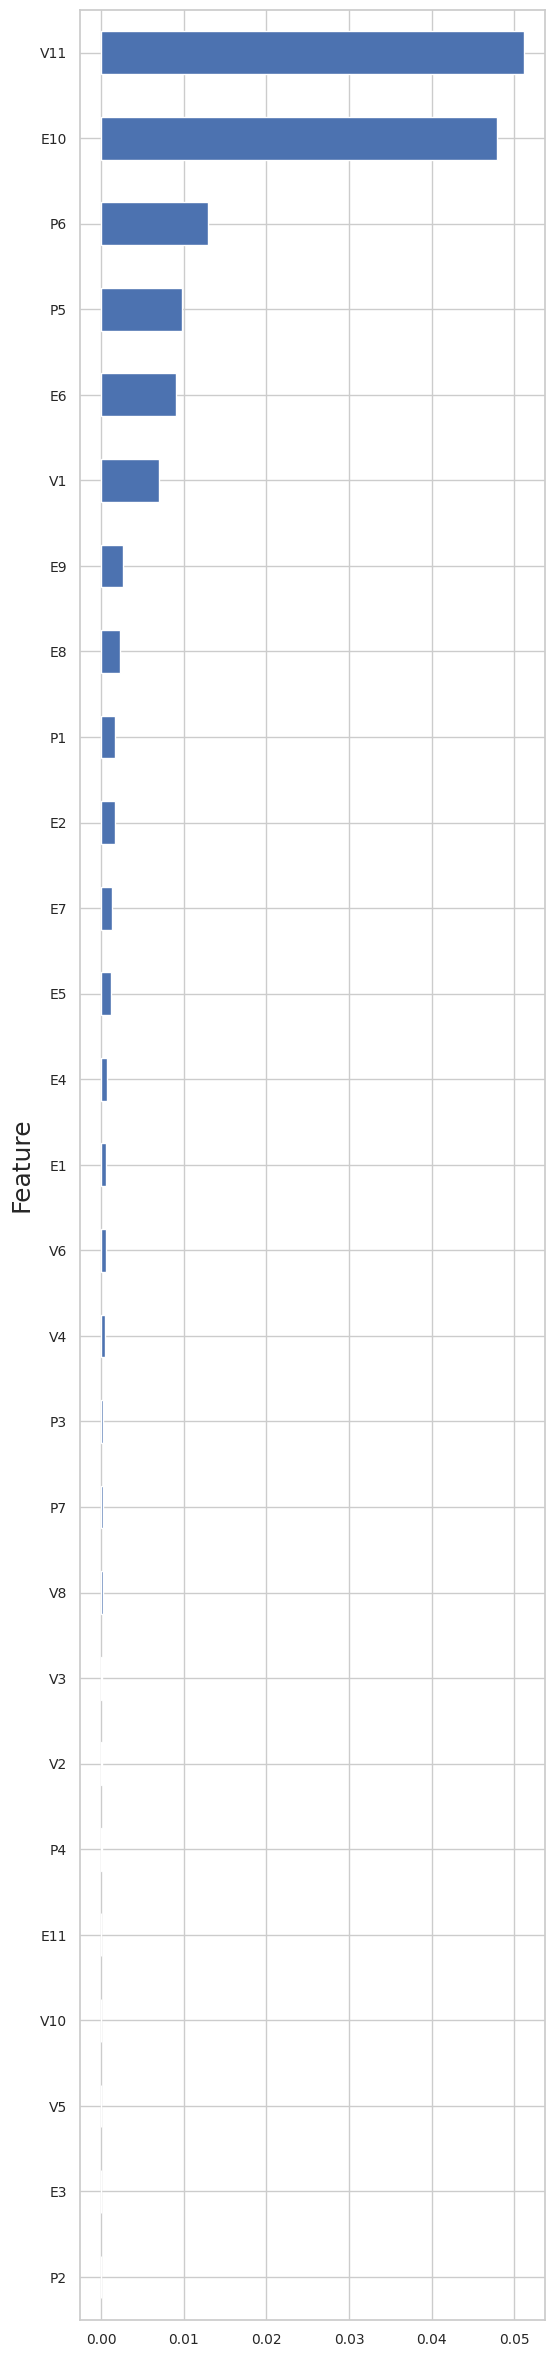

In [31]:
accurate_fi.set_index('Feature')['Importance'].plot.barh(figsize=(6, 30), grid=True, rot=0)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.gca().invert_yaxis()
plt.show()

# Решение LAMA TabularUtilizedAutoML

In [32]:
RDU = ReportDecoUtilized(output_path = 'tabularUtilizedAutoML_model_report')

automl_rdu = RDU(
    TabularUtilizedAutoML(
        task = task,
        timeout = 900,
        cpu_limit = N_THREADS,
        reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
    )
)

In [33]:
out_of_fold_predictions = automl_rdu.fit_predict(train_data, roles = roles, verbose = 1)

[23:23:26] Start automl utilizator with listed constraints:
[23:23:26] - time: 900.00 seconds
[23:23:26] - CPU: 4 cores
[23:23:26] - memory: 16 GB

[23:23:26] If one preset completes earlier, next preset configuration will be started

[23:23:26] ==================================================
[23:23:26] Start 0 automl preset configuration:
[23:23:26] conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'nn_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[23:23:26] Stdout logging level is INFO.
[23:23:26] Task: binary

[23:23:26] Start automl preset with listed constraints:
[23:23:26] - time: 900.00 seconds
[23:23:26] - CPU: 4 cores
[23:23:26] - memory: 16 GB

[23:23:26] Train data shape: (483463, 28)

[23:23:31] Layer 1 train process start. Time left 895.16 secs
[23:23:51] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[23:24:12] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.9362823464807061
[23:24:12] Lvl_0_Pipe_0

Optimization Progress:   1%|          | 1/101 [01:46<2:57:52, 106.73s/it, best_trial=0, best_value=0.975]

[23:32:28] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[23:32:28] Time left 358.32 secs

[23:32:28] Time limit exceeded in one of the tasks. AutoML will blend level 1 models.

[23:32:28] Layer 1 training completed.

[23:32:28] Blending: optimization starts with equal weights. Score = 0.9569865


[23:32:30] Blending: iteration 0: score = 0.9983644, weights = [0. 1. 0.]
[23:32:31] Blending: no improvements for score. Terminated.

[23:32:31] Blending: best score = 0.9983644, best weights = [0. 1. 0.]
[23:32:31] Automl preset training completed in 544.77 seconds

[23:32:31] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (1 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) 

[23:32:31] ==================================================


In [34]:
train_predictions = automl_rdu.predict(train_data)
print(f'Prediction for test_data:\n{train_predictions}\nShape = {train_predictions.shape}')

Prediction for test_data:
array([[3.6926729e-05],
       [3.5181447e-04],
       [9.9975944e-01],
       ...,
       [9.9733490e-01],
       [1.3374084e-03],
       [9.9788868e-01]], dtype=float32)
Shape = (483463, 1)


In [35]:
test_predictions = automl_rdu.predict(test_data)
print(f'Prediction for test_data:\n{test_predictions}\nShape = {test_predictions.shape}')

Prediction for test_data:
array([[9.9991721e-01],
       [9.8789865e-01],
       [1.4618946e-04],
       ...,
       [9.9989915e-01],
       [9.8662621e-01],
       [9.9522203e-01]], dtype=float32)
Shape = (120866, 1)


In [36]:
lama_train_roc_rdu = roc_auc_score(train_data[TARGET_NAME].values, train_predictions.data[:, 0])
lama_test_roc_rdu = roc_auc_score(test_data[TARGET_NAME].values, test_predictions.data[:, 0])
print(f'OOF score: {lama_train_roc_rdu}')
print(f'HOLDOUT score: {lama_test_roc_rdu}')

OOF score: 0.9998666266862338
HOLDOUT score: 0.9990136370121494


In [59]:
if lama_test_roc_rdu > lama_test_roc:
    print(f"Choose the TabularUtilizerAutoML model ")
    print(f"Division by ROC AUC: {lama_test_roc_rdu - lama_test_roc}")
else:
    print(f"Choose the TabularAutoML model ")
    print(f"Division by ROC AUC: {lama_test_roc - lama_test_roc_rdu}")

Choose the TabularAutoML model 
Division by ROC AUC: 0.00019167677259745997


# Собственные решение

In [37]:
# Собственное решение
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

## Первое решение

In [38]:
# Пайплайн
pipeline_rfc = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier())
])

# Оптимизация гиперпараметров
param_grid_rfc = {
    'classifier__n_estimators': [200, 300],
    'classifier__max_depth': [20, 30]
}

In [39]:
grid_search_rfc = GridSearchCV(pipeline_rfc, param_grid_rfc, cv=N_FOLDS, scoring='roc_auc',verbose=10)
grid_search_rfc.fit(train_data.drop(columns=[TARGET_NAME]), train_data[TARGET_NAME])

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START classifier__max_depth=20, classifier__n_estimators=200......
[CV 1/5; 1/4] END classifier__max_depth=20, classifier__n_estimators=200;, score=0.997 total time= 4.0min
[CV 2/5; 1/4] START classifier__max_depth=20, classifier__n_estimators=200......
[CV 2/5; 1/4] END classifier__max_depth=20, classifier__n_estimators=200;, score=0.997 total time= 4.0min
[CV 3/5; 1/4] START classifier__max_depth=20, classifier__n_estimators=200......
[CV 3/5; 1/4] END classifier__max_depth=20, classifier__n_estimators=200;, score=0.997 total time= 3.9min
[CV 4/5; 1/4] START classifier__max_depth=20, classifier__n_estimators=200......
[CV 4/5; 1/4] END classifier__max_depth=20, classifier__n_estimators=200;, score=0.997 total time= 3.9min
[CV 5/5; 1/4] START classifier__max_depth=20, classifier__n_estimators=200......
[CV 5/5; 1/4] END classifier__max_depth=20, classifier__n_estimators=200;, score=0.997 total time= 3.9min
[CV 1

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('scaler', StandardScaler()),
                                       ('classifier',
                                        RandomForestClassifier())]),
             param_grid={'classifier__max_depth': [20, 30],
                         'classifier__n_estimators': [200, 300]},
             scoring='roc_auc', verbose=10)

In [40]:
# Лучшая модель
best_model_rfc = grid_search_rfc.best_estimator_
print(f'Best model: {best_model_rfc}')

Best model: Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(max_depth=30, n_estimators=300))])


In [41]:
# Оценка модели
train_predictions_gs_rfc = best_model_rfc.predict_proba(train_data.drop(columns=[TARGET_NAME]))[:, 1]
test_predictions_gs_rfc = best_model_rfc.predict_proba(test_data.drop(columns=[TARGET_NAME]))[:, 1]

In [42]:
grid_train_rfc_roc = roc_auc_score(train_data[TARGET_NAME].values, train_predictions_gs_rfc)
grid_test_rfc_roc = roc_auc_score(test_data[TARGET_NAME].values, test_predictions_gs_rfc)
print(f'OOF score: {grid_train_rfc_roc}')
print(f'HOLDOUT score: {grid_test_rfc_roc}')

OOF score: 0.9999999992980334
HOLDOUT score: 0.9998526192030636


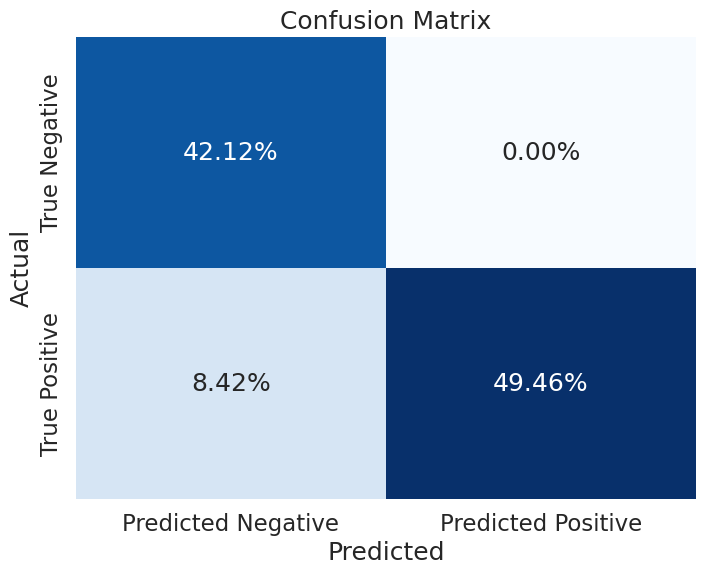

In [43]:
gs_conf_matrix_rfc = confusion_matrix(test_data[TARGET_NAME].values, np.int32(np.round(test_predictions_gs_rfc, 1)))
gs_percentage_matrix_rfc = (gs_conf_matrix_rfc / gs_conf_matrix_rfc.sum().sum())
# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(gs_percentage_matrix_rfc, annot=True, fmt='.2%', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['True Negative', 'True Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [44]:
if lama_test_roc_rdu < grid_test_rfc_roc > lama_test_roc:
    print("✅ Custom model better than LAMA solution on validation dataset")
    print("Difference with TabularAutoML is equal ", grid_test_rfc_roc - lama_test_roc)
    print("Difference with TabularUtilizedAutoML is equal ", grid_test_rfc_roc - lama_test_roc_rdu)
else:
    print("❌ Custom model worse than LAMA solution on validation dataset")

✅ Custom model better than LAMA solution on validation dataset
Difference with TabularAutoML is equal  0.0006473054183167015
Difference with TabularUtilizedAutoML is equal  0.0008389821909141615


## Второе решение

In [45]:
# Создание пайплайна
pipeline_gbc = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Замена пропущенных значений
    ('scaler', StandardScaler()),                # Нормализация данных
    ('classifier', GradientBoostingClassifier()) # Классификатор Gradient Boosting
])

# Сетка гиперпараметров
param_grid_gbc = {
    'classifier__n_estimators': [200],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__max_depth': [3, 5]
}

In [46]:
grid_search_gbc = GridSearchCV(pipeline_gbc, param_grid_gbc, cv=N_FOLDS, scoring='roc_auc',verbose=10)
grid_search_gbc.fit(train_data.drop(columns=[TARGET_NAME]), train_data[TARGET_NAME])

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=200


[CV 1/5; 1/4] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=200;, score=0.901 total time= 5.7min
[CV 2/5; 1/4] START classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=200
[CV 2/5; 1/4] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=200;, score=0.903 total time= 5.7min
[CV 3/5; 1/4] START classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=200
[CV 3/5; 1/4] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=200;, score=0.902 total time= 5.7min
[CV 4/5; 1/4] START classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=200
[CV 4/5; 1/4] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=200;, score=0.903 total time= 5.7min
[CV 5/5; 1/4] START classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=200
[CV 5/5; 1/4] END classifier

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('scaler', StandardScaler()),
                                       ('classifier',
                                        GradientBoostingClassifier())]),
             param_grid={'classifier__learning_rate': [0.01, 0.1],
                         'classifier__max_depth': [3, 5],
                         'classifier__n_estimators': [200]},
             scoring='roc_auc', verbose=10)

In [47]:
# Лучшая модель
best_model_gbc = grid_search_gbc.best_estimator_
print(f'Best model: {best_model_gbc}')

Best model: Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('classifier',
                 GradientBoostingClassifier(max_depth=5, n_estimators=200))])


In [48]:
# Оценка модели
train_predictions_gs_gbc = best_model_gbc.predict_proba(train_data.drop(columns=[TARGET_NAME]))[:, 1]
test_predictions_gs_gbc = best_model_gbc.predict_proba(test_data.drop(columns=[TARGET_NAME]))[:, 1]

In [49]:
grid_train_roc_gbc = roc_auc_score(train_data[TARGET_NAME].values, train_predictions_gs_gbc)
grid_test_roc_gbc = roc_auc_score(test_data[TARGET_NAME].values, test_predictions_gs_gbc)
print(f'OOF score: {grid_train_roc_gbc}')
print(f'HOLDOUT score: {grid_test_roc_gbc}')

OOF score: 0.9737763780849704
HOLDOUT score: 0.9725089692931261


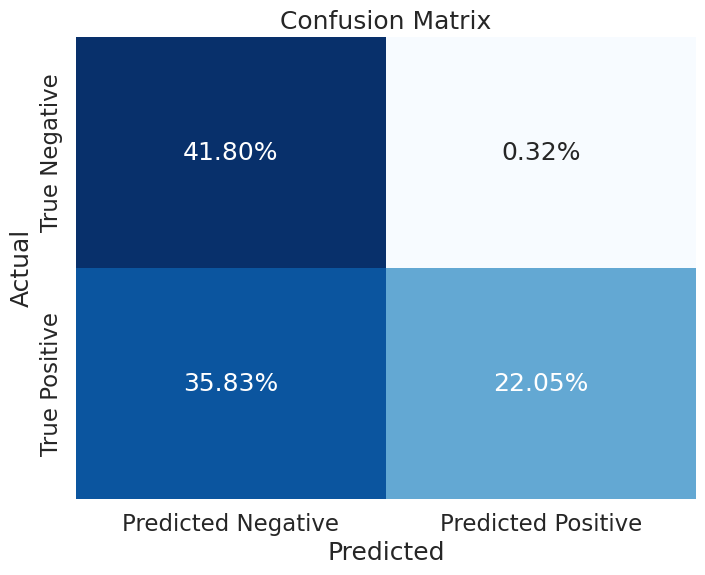

In [50]:
gs_conf_matrix_gbc = confusion_matrix(test_data[TARGET_NAME].values, np.int32(np.round(test_predictions_gs_gbc, 1)))
gs_percentage_matrix_gbc = (gs_conf_matrix_gbc / gs_conf_matrix_gbc.sum().sum())
# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(gs_percentage_matrix_gbc, annot=True, fmt='.2%', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['True Negative', 'True Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [51]:
if lama_test_roc_rdu < grid_test_roc_gbc > lama_test_roc:
    print("✅ Custom model better than LAMA solution on validation dataset")
    print("Difference with TabularAutoML is equal ", grid_test_roc_gbc - lama_test_roc)
    print("Difference with TabularUtilizedAutoML is equal ", grid_test_roc_gbc - lama_test_roc_rdu)
else:
    print("❌ Custom model worse than LAMA solution on validation dataset")

❌ Custom model worse than LAMA solution on validation dataset


## Третье решение

In [52]:
pipeline_knn = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Замена пропущенных значений
    ('scaler', StandardScaler()),                # Нормализация данных
    ('classifier', KNeighborsClassifier())       # Классификатор KNN
])

# Сетка гиперпараметров
param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7],        # Количество соседей
    'classifier__weights': ['uniform', 'distance'],  # Веса соседей
    'classifier__metric': ['euclidean', 'manhattan']  # Метрика расстояния
}

In [53]:
grid_search_knn = GridSearchCV(pipeline_knn, param_grid_knn, cv=N_FOLDS, scoring='roc_auc',verbose=30)
grid_search_knn.fit(train_data.drop(columns=[TARGET_NAME]), train_data[TARGET_NAME])

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[CV 1/5; 1/12] START classifier__metric=euclidean, classifier__n_neighbors=3, classifier__weights=uniform
[CV 1/5; 1/12] END classifier__metric=euclidean, classifier__n_neighbors=3, classifier__weights=uniform;, score=0.977 total time=  55.1s
[CV 2/5; 1/12] START classifier__metric=euclidean, classifier__n_neighbors=3, classifier__weights=uniform
[CV 2/5; 1/12] END classifier__metric=euclidean, classifier__n_neighbors=3, classifier__weights=uniform;, score=0.976 total time=  54.6s
[CV 3/5; 1/12] START classifier__metric=euclidean, classifier__n_neighbors=3, classifier__weights=uniform
[CV 3/5; 1/12] END classifier__metric=euclidean, classifier__n_neighbors=3, classifier__weights=uniform;, score=0.975 total time=  54.8s
[CV 4/5; 1/12] START classifier__metric=euclidean, classifier__n_neighbors=3, classifier__weights=uniform
[CV 4/5; 1/12] END classifier__metric=euclidean, classifier__n_neighbors=3, classifier__weights=uniform;, score=0.975 total time=  54.9s
[CV 5/5; 1/12] START classif

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('scaler', StandardScaler()),
                                       ('classifier', KNeighborsClassifier())]),
             param_grid={'classifier__metric': ['euclidean', 'manhattan'],
                         'classifier__n_neighbors': [3, 5, 7],
                         'classifier__weights': ['uniform', 'distance']},
             scoring='roc_auc', verbose=30)

In [54]:
# Лучшая модель
best_model_knn = grid_search_knn.best_estimator_
print(f'Best model: {best_model_knn}')

Best model: Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('classifier',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=7,
                                      weights='distance'))])


In [55]:
# Оценка модели
train_predictions_gs_knn = best_model_knn.predict_proba(train_data.drop(columns=[TARGET_NAME]))[:, 1]
test_predictions_gs_knn = best_model_knn.predict_proba(test_data.drop(columns=[TARGET_NAME]))[:, 1]

In [56]:
grid_train_roc_knn = roc_auc_score(train_data[TARGET_NAME].values, train_predictions_gs_knn)
grid_test_roc_knn = roc_auc_score(test_data[TARGET_NAME].values, test_predictions_gs_knn)
print(f'OOF score: {grid_train_roc_knn}')
print(f'HOLDOUT score: {grid_test_roc_knn}')

OOF score: 1.0
HOLDOUT score: 0.9967774310229023


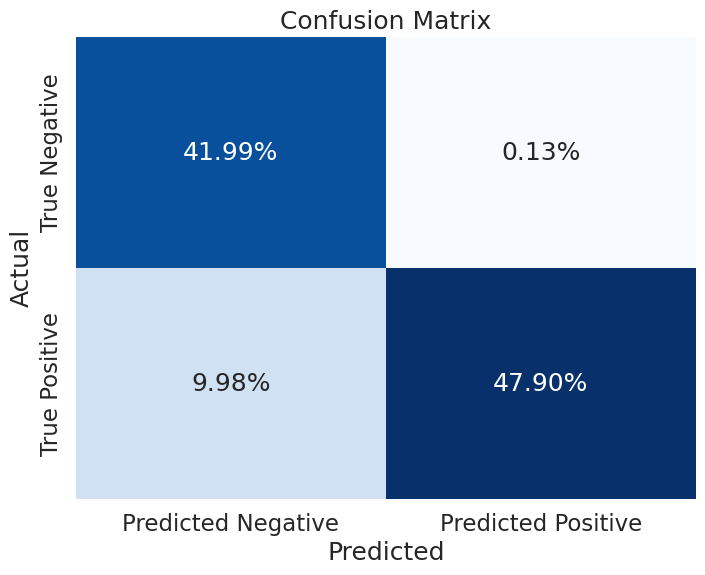

In [57]:
gs_conf_matrix_knn = confusion_matrix(test_data[TARGET_NAME].values, np.int32(np.round(test_predictions_gs_knn, 1)))
gs_percentage_matrix_knn = (gs_conf_matrix_knn / gs_conf_matrix_knn.sum().sum())
# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(gs_percentage_matrix_knn, annot=True, fmt='.2%', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['True Negative', 'True Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [58]:
if lama_test_roc_rdu < grid_test_roc_knn > lama_test_roc:
    print("✅ Custom model better than LAMA solution on validation dataset")
    print("Difference with TabularAutoML is equal ", grid_test_roc_knn - lama_test_roc)
    print("Difference with TabularUtilizedAutoML is equal ", grid_test_roc_knn - lama_test_roc_rdu)
else:
    print("❌ Custom model worse than LAMA solution on validation dataset")

❌ Custom model worse than LAMA solution on validation dataset


# Вывод

Light Auto ML действительно является мощным инструментом для упрощения работы ML инженеру, но полностью полагаться только на него не стоит. Можно самостоятельно создать модель, которая не будет уступать по метрикам.

### ROC/AUC:
| Модель | ROC/AUC |
|----------|----------|
|TabularAutoML | 0.99920 |
|TabularUtilizedAutoML | 0.99901 | 
|RandomForestClassifier | 0.99985 |
|GradientBoostingClassifier | 0.97250 |
|KNeighborsClassifier | 0.99677 |